# Drought Analysis

## Request
Using NASA remote sensing data, prepare historical drought analysis for Niger and bordering countries. Estimate hectares of farmland where drought has occurred over the past 5 years. 

## Drought Index
There are several drought indices in the literature, the majority of them look a trends in rainfall and temperature to identify droughts at different time intervals. We use the [Standardised Precipitation-Evapotranspiration Index (SPEI)](https://spei.csic.es/home.html)  

### SPEI
The [SPEI](https://spei.csic.es) is an extension of the widely used Standardized Precipitation Index (SPI). The SPEI is designed to take into account both `precipitation` and `potential evapotranspiration` (PET) in determining drought. Thus, unlike the SPI, the SPEI captures the main impact of increased temperatures on water demand.  

The idea behind the SPEI is to compare the highest possible evapotranspiration (what we call the evaporative demand by the atmosphere) with the current water availability. Thus, precipitation (accumulated over a period of time) in the SPEI stands for the water availability, while ETo stands for the atmospheric water demand.  

### Time Scales
The SPEI can measure different types of drought (levels of severity and duration) depending on the time timescale factor. At the shortest time scales (3/6 months) the drought series show a high frequency of drought, and moist periods of short duration. In contrast, at the longest time scales (12/18 months) the drought periods are of longer duration and lower frequency.

### Interpretation

Negative SPEI values represent rainfall deficit and high potential epotranspiration (dry conditions), starting when the SPEI value is equal or below -1.0. Whereas positive SPEI values indicate rainfall surplus and low potential epotranspiration (wet conditions), starting when the SPEI value is equal or above 1.0.

## Maps of Monthly SPEI (6-month window)

Each row in this panel of maps is a year, and each column is a month. Red values signify dry conditions (drought), and blue values signify wet conditions.

C:\Users\WB514197\AppData\Local\Temp\ipykernel_28692\3436898147.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centx, centy = one.centroid.x.iloc[0], one.centroid.y.iloc[0]


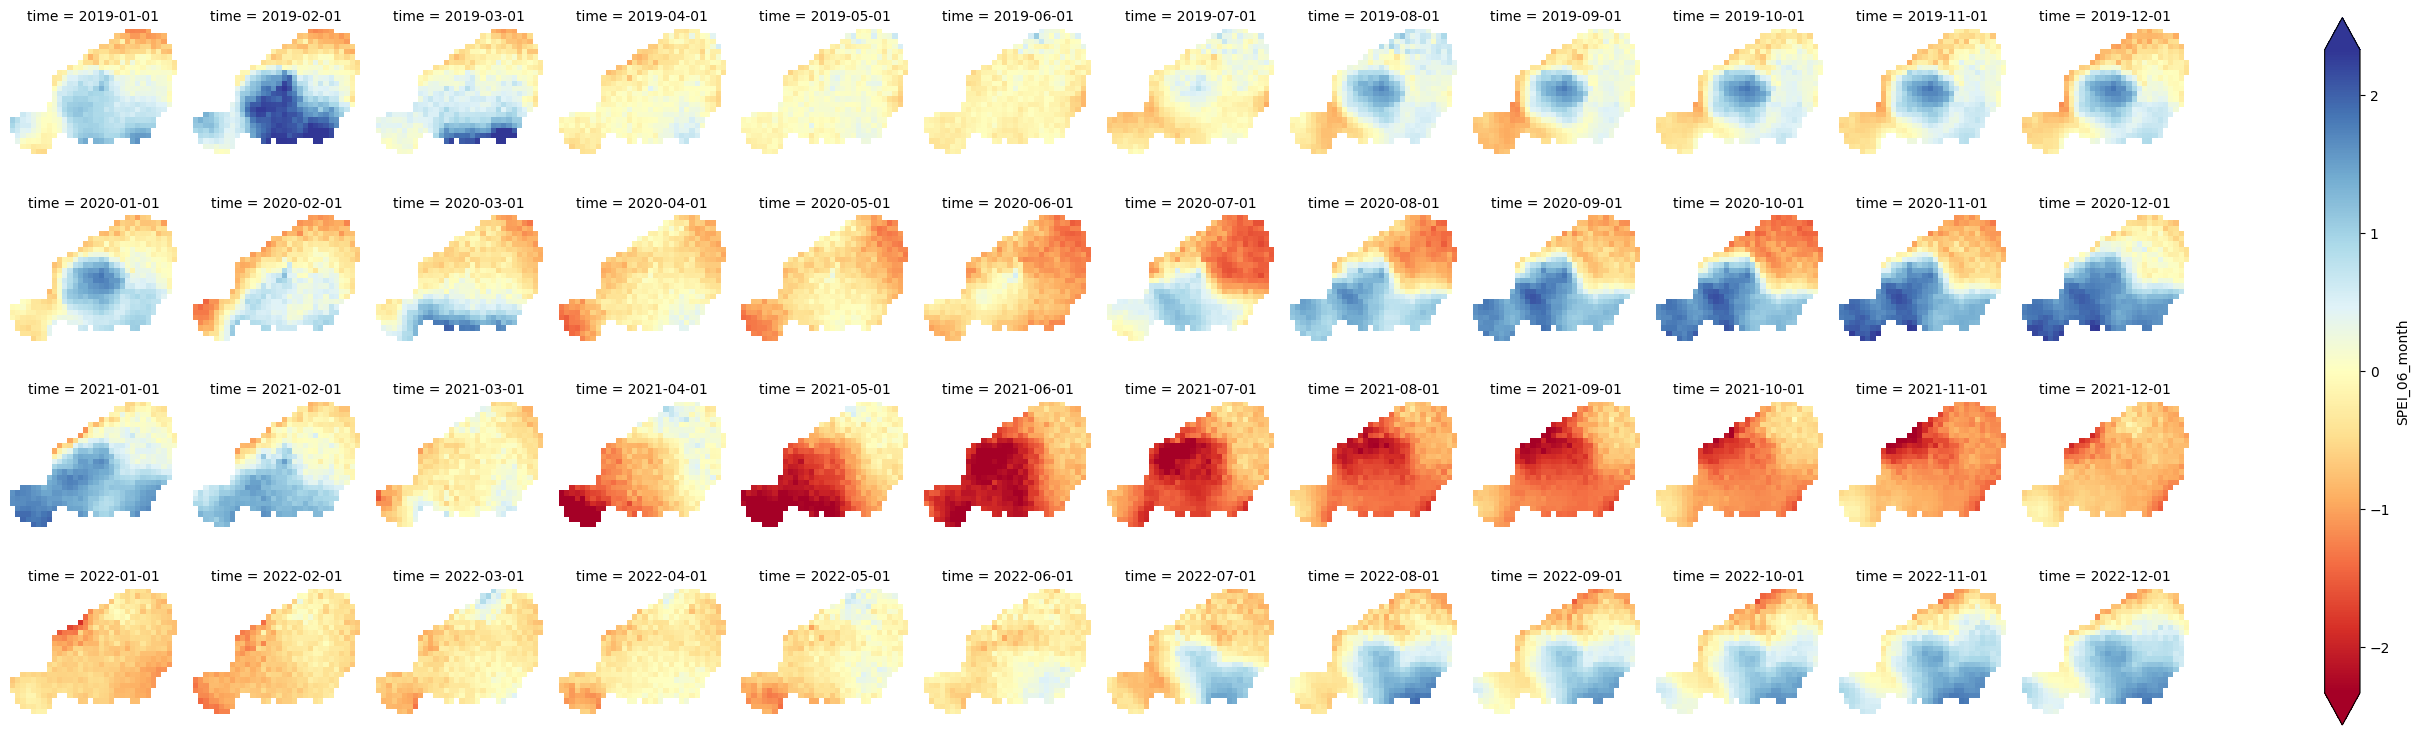

In [1]:
# Imports
import ee

ee.Initialize()
import requests
import geopandas as gpd
from geemap.conversion import *
import xarray as xr
import matplotlib.pyplot as plt

# Admin Data
adm = "ADM0"
iso3 = "NER"
release_type = "gbOpen"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
try:
    res = requests.get(geo_url).json()
    adm0_ner = gpd.read_file(res["gjDownloadURL"])
    # adm0_ner.to_file('../../data/adm0_ner.geojson', driver='GeoJSON')
except:
    adm0_ner = gpd.read_file("../../data/adm0_ner.geojson")

one = adm0_ner.iloc[[0]]
centx, centy = one.centroid.x.iloc[0], one.centroid.y.iloc[0]
aoi = gdf_to_ee(adm0_ner)

spei = (
    ee.ImageCollection("CSIC/SPEI/2_9")
    .select("SPEI_06_month")
    .filterDate("2019-01-01", "2023-12-31")
)


def clip_image(image):
    return image.clip(aoi)


spei = spei.map(clip_image)

ds = xr.open_dataset(
    spei,
    engine="ee",
    geometry=aoi.geometry(),
    crs="EPSG:4326",
    scale=0.5,
)
ax = ds["SPEI_06_month"].plot.imshow(
    robust=True,
    x="lon",
    y="lat",
    cmap="RdYlBu",
    vmin=-2.33,
    vmax=2.33,
    col="time",
    col_wrap=12,
    figsize=(28, 8),
)  # figsize=(10, 10) aspect=2, size=10
ax.map(lambda: plt.axis("off"))
for a in ax.axs.flat:
    a.set_aspect("equal")

The Global SPEI Database only contains data up to 2022. The authors also provide less accurate but real-time data through the [SPEI Global Drought Monitor](https://spei.csic.es/map/maps.html#months=1#month=3#year=2024). In the maps below, we show the progression of SPEI for 2023 and 2024, using the coarser (1 degree resolution) real-time data.  

*An important difference between the data sources is that the SPEI Global Drought Monitor is based on the Thortnthwaite equation for estimating potential evapotranspiration, PET. This is due to the lack of real-time data sources for computing more robust PET estimations which have larger data requirements.*

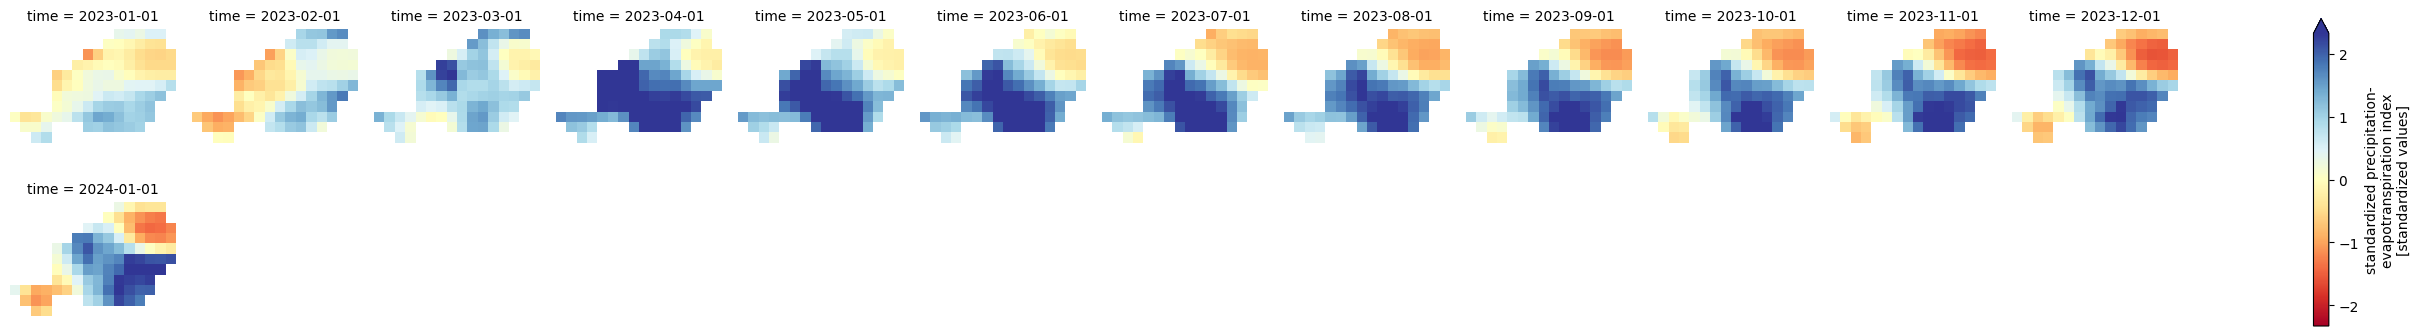

In [2]:
from os.path import join, expanduser

# Download from https://spei.csic.es/map/maps.html
ds2 = xr.open_dataset(join(expanduser("~"), "Downloads", "spei06.nc"))
ds2 = ds2.isel(lat=slice(None, None, -1))
# slice time dimension
ds2 = ds2.sel(time=slice("2023-01-01", "2024-12-31"))
ds2.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ds2.rio.write_crs("EPSG:4326", inplace=True)
clipped = ds2.rio.clip(adm0_ner.geometry.values, adm0_ner.crs, drop=True, invert=False)
ax = clipped["spei"].plot(
    robust=True,
    x="lon",
    y="lat",
    cmap="RdYlBu",
    vmin=-2.33,
    vmax=2.33,
    col="time",
    col_wrap=12,
    figsize=(28, 4),
)  # figsize=(10, 10) aspect=2, size=10
ax.map(lambda: plt.axis("off"))
for a in ax.axs.flat:
    a.set_aspect("equal")

## Trend of SPEI (6-month) in Niger

The chart below shows the historical trend in SPEI 6-month from 2016 to 2023 using the median value.

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\layer.py:344: PlotnineWarning: position_stack : Removed 1 rows containing missing values.


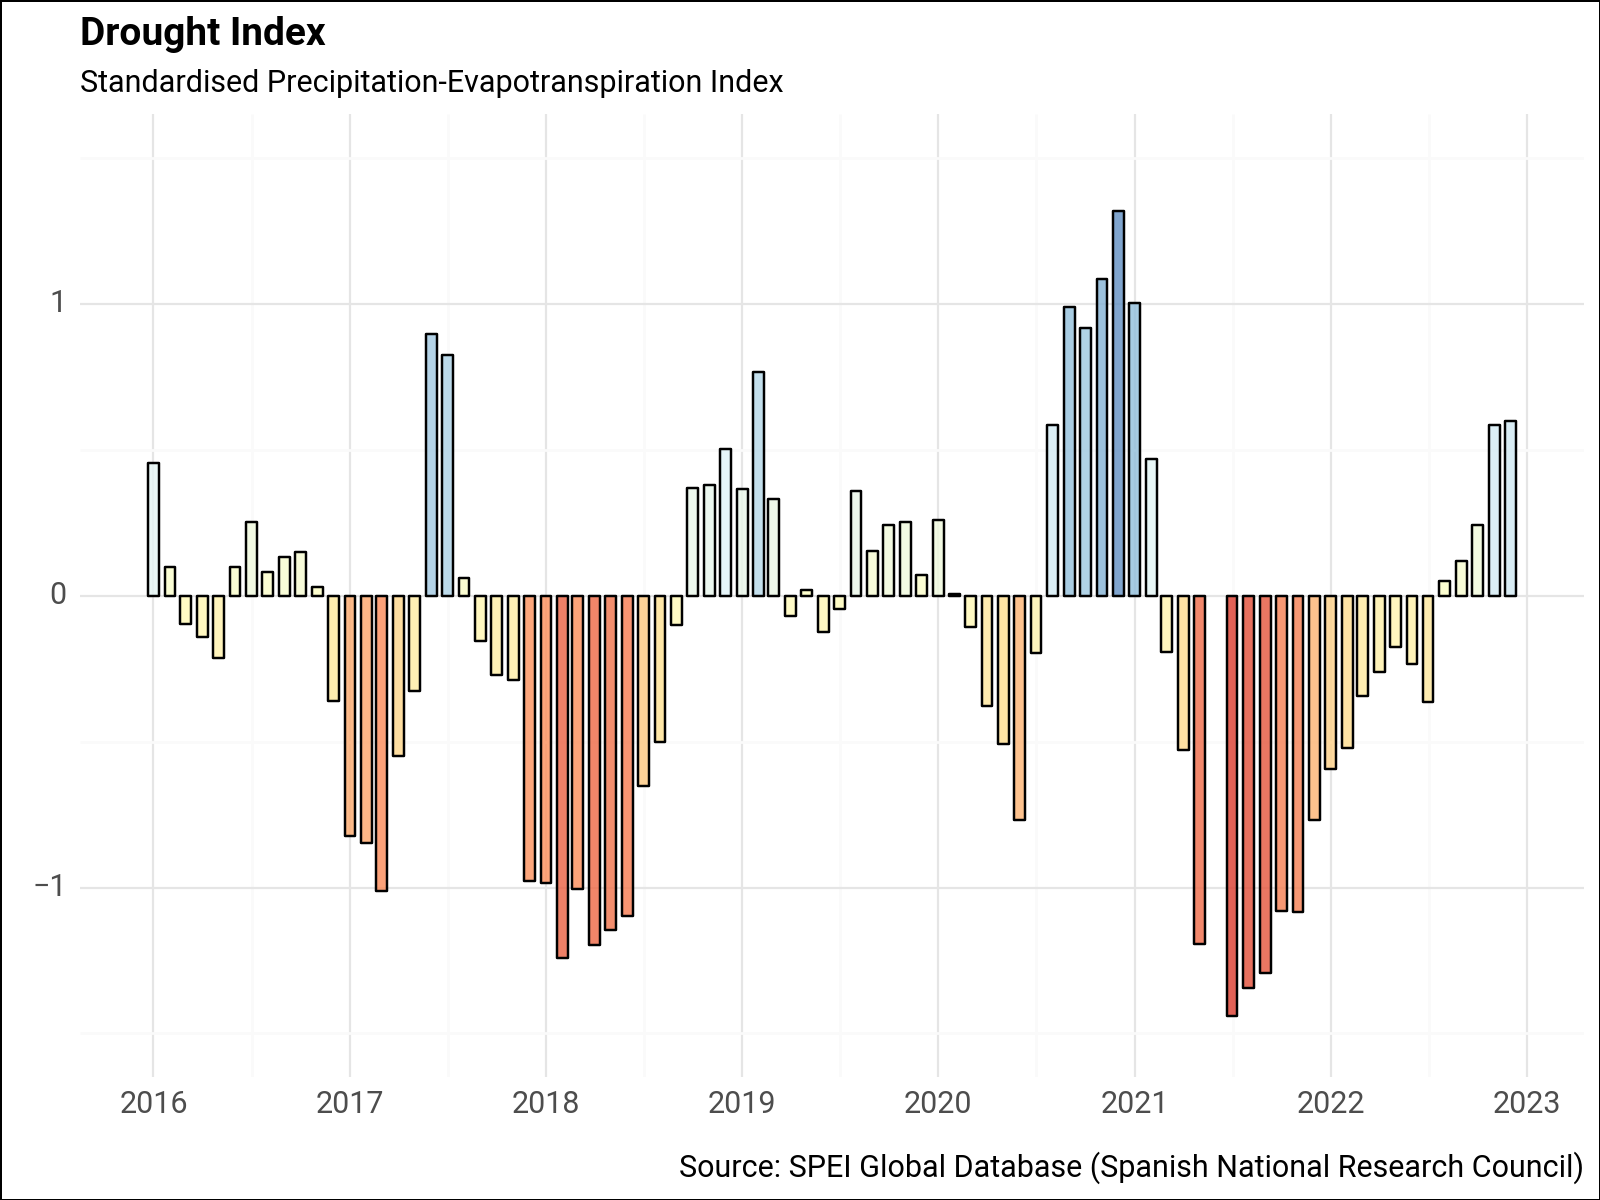

<Figure Size: (800 x 600)>

In [3]:
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format

spei = (
    ee.ImageCollection("CSIC/SPEI/2_9")
    .select("SPEI_06_month")
    .filterDate("2016-01-01", "2023-12-31")
)


def clip_image(image):
    return image.clip(aoi)


spei = spei.map(clip_image)

ds = xr.open_dataset(
    spei,
    engine="ee",
    geometry=aoi.geometry(),
    crs="EPSG:4326",
    scale=0.5,
)

country_median = ds.median(dim=["lat", "lon"])
df = country_median["SPEI_06_month"].to_dataframe().reset_index()
df.loc[:, "ymd"] = df["time"].dt.strftime("%Y-%m-%d")
df.loc[:, "group"] = 1

font = "Roboto"
p = (
    ggplot(df, aes(x="ymd", y="SPEI_06_month", group="group", fill="SPEI_06_month"))
    + geom_bar(alpha=0.8, stat="identity", color="black", width=20)
    + labs(
        x="",
        subtitle="Standardised Precipitation-Evapotranspiration Index",
        title="Drought Index",
        y="",
        caption="Source: SPEI Global Database (Spanish National Research Council)",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        legend_position="none",
    )
    + scale_fill_distiller(
        type="div", palette="RdYlBu", direction=1, limits=(-1.5, 1.5)
    )
    + scale_y_continuous(limits=(-1.5, 1.5))
    + scale_x_datetime(
        breaks=date_breaks("1 year"), labels=date_format("%Y")
    )  # 6 month "%b, %y"
)
p

## Trend of SPEI (12-month) in Niger

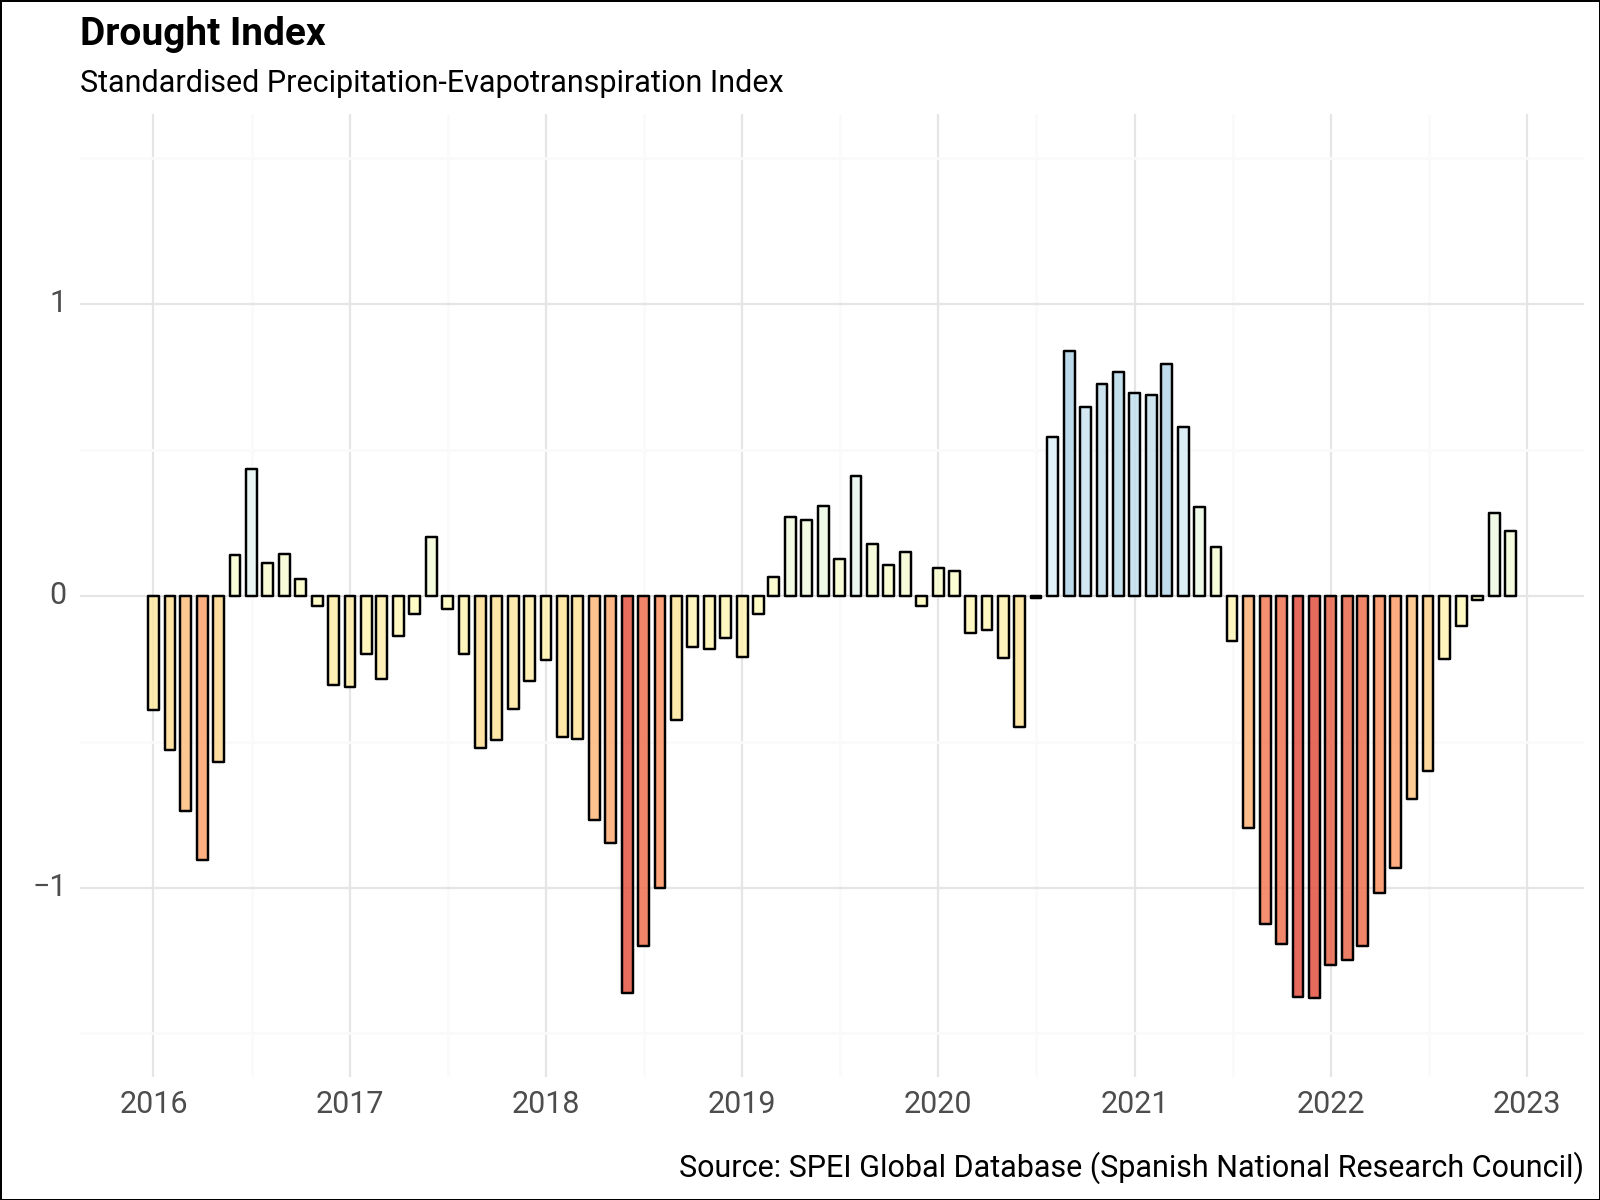

<Figure Size: (800 x 600)>

In [4]:
spei = (
    ee.ImageCollection("CSIC/SPEI/2_9")
    .select("SPEI_12_month")
    .filterDate("2016-01-01", "2023-12-31")
)


def clip_image(image):
    return image.clip(aoi)


spei = spei.map(clip_image)

ds = xr.open_dataset(
    spei,
    engine="ee",
    geometry=aoi.geometry(),
    crs="EPSG:4326",
    scale=0.5,
)

country_median = ds.median(dim=["lat", "lon"])
df = country_median["SPEI_12_month"].to_dataframe().reset_index()
df.loc[:, "ymd"] = df["time"].dt.strftime("%Y-%m-%d")
df.loc[:, "group"] = 1

font = "Roboto"
p = (
    ggplot(df, aes(x="ymd", y="SPEI_12_month", group="group", fill="SPEI_12_month"))
    + geom_bar(alpha=0.8, stat="identity", color="black", width=20)
    + labs(
        x="",
        subtitle="Standardised Precipitation-Evapotranspiration Index",
        title="Drought Index",
        y="",
        caption="Source: SPEI Global Database (Spanish National Research Council)",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        legend_position="none",
    )
    + scale_fill_distiller(
        type="div", palette="RdYlBu", direction=1, limits=(-1.5, 1.5)
    )
    + scale_y_continuous(limits=(-1.5, 1.5))
    + scale_x_datetime(
        breaks=date_breaks("1 year"), labels=date_format("%Y")
    )  # 6 month "%b, %y"
)
p

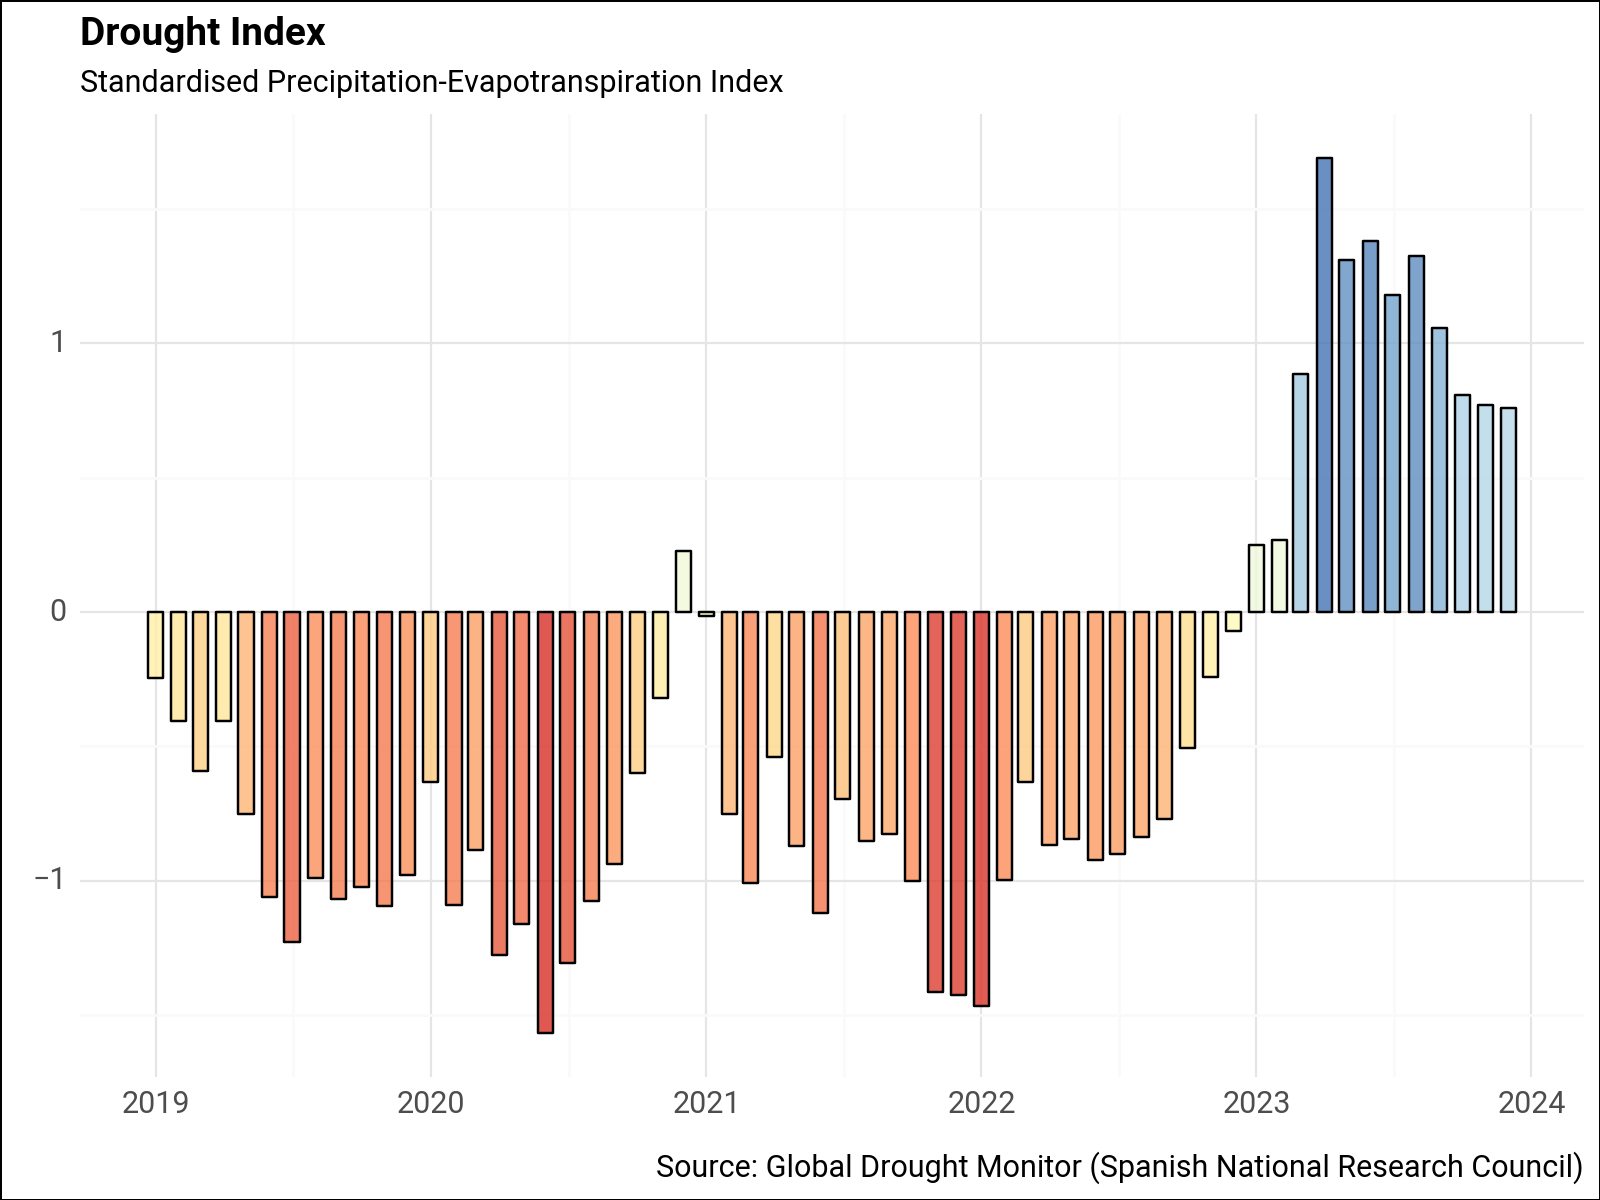

<Figure Size: (800 x 600)>

In [76]:
# pal = colormaps.get_palette('RdYlBu', 10) # Greens BrBG
# visParams = {
#   'min': -2.33,
#   'max':  2.33,
#   'palette': pal
# }

# spei = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").select('spei').filterDate('2019-01-01', '2023-12-31')
# one = spei.first().clip(aoi)


# m = Map(center=[centy, centx], zoom=6) # basemap='Esri.WorldImagery'
# m.addLayer(one, visParams, 'SPEI')
# # m.add_time_slider(spei, visParams, time_interval=1)
# m.addLayerControl()
# m

# Download from https://spei.csic.es/map/maps.html
ds2 = xr.open_dataset(join(expanduser("~"), "Downloads", "spei06.nc"))
ds2 = ds2.isel(lat=slice(None, None, -1))
# slice time dimension
ds2 = ds2.sel(time=slice("2019-01-01", "2023-12-31"))
ds2.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ds2.rio.write_crs("EPSG:4326", inplace=True)
clipped = ds2.rio.clip(adm0_ner.geometry.values, adm0_ner.crs, drop=True, invert=False)

country_median = clipped.median(dim=["lat", "lon"])
df = country_median["spei"].to_dataframe().reset_index()
df.loc[:, "ymd"] = df["time"].dt.strftime("%Y-%m-%d")
df.loc[:, "group"] = 1

font = "Roboto"
p = (
    ggplot(df, aes(x="ymd", y="spei", group="group", fill="spei"))
    + geom_bar(alpha=0.8, stat="identity", color="black", width=20)
    + labs(
        x="",
        subtitle="Standardised Precipitation-Evapotranspiration Index",
        title="Drought Index",
        y="",
        caption="Source: Global Drought Monitor (Spanish National Research Council)",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        legend_position="none",
    )
    + scale_fill_distiller(
        type="div", palette="RdYlBu", direction=1, limits=(-1.5, 1.5)
    )
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
)
p